In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle"
# %cd "/content/gdrive/MyDrive/Colab Notebooks/Kaggle"
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [1]:
#Essential Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
import os
import pickle
import csv

In [2]:
#Reading and preparing the images
images = []
labels = []
limit=400
img_size=256

main_path='./chest_xray/chest_xray/train/'
folder_names = []
for entry_name in os.listdir('./chest_xray/chest_xray/train/'):
    entry_path = os.path.join('./chest_xray/chest_xray/train/', entry_name)
    if os.path.isdir(entry_path):
        folder_names.append(entry_name)
        
print('The Categories are',folder_names)

j=0
for folder in folder_names:
    for filename in os.listdir(os.path.join(main_path,folder)):
        img_path = os.path.join(main_path,folder)
        img = cv2.imread(os.path.join(img_path,filename)) 
        if img is not None:
            img  = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)   
            img = cv2.resize(img,(img_size, img_size))
            images.append(img)
            if folder == 'NORMAL':
                labels.append(0)
                #print('normal')
            else:
                labels.append(1)
                #print('PNE')
        j=j+1
        if j >= limit:
            j=0
            break
            
images,labels=np.array(images),np.array(labels)
print(images.shape)
#print(labels)

The Categories are ['NORMAL', 'PNEUMONIA']
(800, 256, 256)


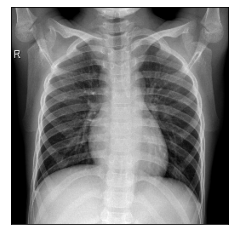

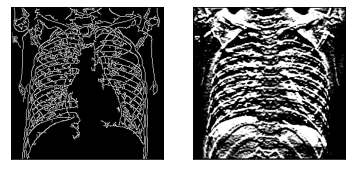

In [3]:
#Printing a random sample
from random import randrange

i = randrange(limit*2)

plt.imshow(images[i],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

#Canny
canny = cv2.Canny(images[i],40,200)


#Sobel
sobelY = cv2.Sobel(images[i],cv2.CV_8UC1,0,1,ksize=5)

preview = [canny,sobelY]
i=0
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(preview[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
#Obtaining Variance of images
kernel = np.ones((3,3),np.uint8)
var_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    var_vector[i] = np.var(x)
    i=i+1
#print(var_vector[6])

In [5]:
#Obtaining Mean of images
mean_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    mean_vector[i] = np.mean(x)
    i=i+1
#print(mean_vector)

In [6]:
#Obtaining Standard Deviation of images
std_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    std_vector[i] = np.std(x)
    i=i+1
#print(std_vector)

In [7]:
#Obtaining Skewness of images
skew_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    skew_vector[i] = stats.skew(x)
    i=i+1
#print(skew_vector)

In [8]:
#Obtaining Kurtosis of images
kurto_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    kurto_vector[i] = stats.kurtosis(x)
    i=i+1
#print(kurto_vector)

In [9]:
#Obtaining Entropy of images
entropy_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    entropy_vector[i] = stats.entropy(x)
    i=i+1
#print(entropy_vector)

In [10]:
#Applying Canny edge detection
canny_vector = np.empty((limit*2,img_size*img_size))
i = 0
for image in images:
    canny = cv2.Canny(image,40,200)
    canny_vector[i] = np.array(canny.flatten())
    i=i+1
#print(canny_vector[1])

In [11]:
#Applying Sobel X
sobelX_vector = np.empty((limit*2,img_size*img_size))
i = 0
for image in images:
    sobelX = cv2.Sobel(image,cv2.CV_8UC1,1,0,ksize=5)
    sobelX_vector[i] = np.array(sobelX.flatten())
    i=i+1

In [12]:
#Applying Sobel Y
sobelY_vector = np.empty((limit*2,img_size*img_size))
i = 0
for image in images:
    sobelY = cv2.Sobel(image,cv2.CV_8UC1,0,1,ksize=5)
    sobelY_vector[i] = np.array(sobelY.flatten())
    i=i+1

In [13]:
feature_vector = np.empty((limit*2,0))
feature_vector=np.append(feature_vector,mean_vector,axis=1)
feature_vector=np.append(feature_vector,var_vector,axis=1)
feature_vector=np.append(feature_vector,std_vector,axis=1)
feature_vector=np.append(feature_vector,skew_vector,axis=1)
feature_vector=np.append(feature_vector,kurto_vector,axis=1)
feature_vector=np.append(feature_vector,entropy_vector,axis=1)
feature_vector=np.append(feature_vector,canny_vector,axis=1)
feature_vector=np.append(feature_vector,sobelX_vector,axis=1)
#feature_vector=np.append(feature_vector,sobelY_vector,axis=1)
#print(feature_vector[0])
#feature_vector=np.append(feature_vector,,axis=1)

In [14]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(feature_vector,labels,test_size=0.2,shuffle=True)#80% training

print(xtrain.shape)

(640, 131078)


0.8625


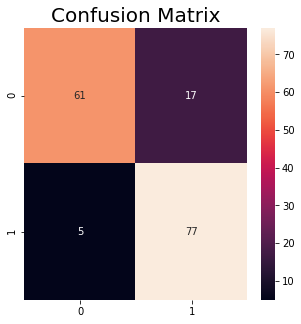

              precision    recall  f1-score   support

           0       0.92      0.78      0.85        78
           1       0.82      0.94      0.88        82

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160



In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

RF=RandomForestClassifier(max_depth=10,n_estimators=150)
RF.fit(xtrain,ytrain)

ypredict = RF.predict(xtest)

print(RF.score(xtest,ytest))
cm = confusion_matrix(ytest, ypredict)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

print(classification_report(ytest,ypredict))

0.71875


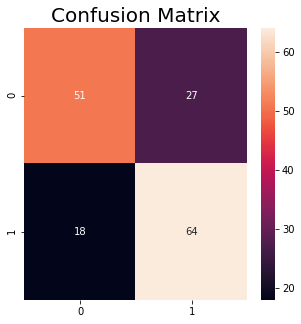

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        78
           1       0.70      0.78      0.74        82

    accuracy                           0.72       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.72      0.72      0.72       160



In [16]:
from sklearn import svm
clf = svm.SVC()
clf.fit(xtrain, ytrain)
print(clf.score(xtest,ytest))

ypredict = clf.predict(xtest)

cm = confusion_matrix(ytest, ypredict)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

print(classification_report(ytest,ypredict))
